# Make a Churn simulation

Make a simulated population, treat none (no marketing to anyone), learn to predict who-churns-most, output a pickle for use in `make_plots`.

Churn models don't know anything about marketing - they're built before we test a person's reaction to marketing.

* `mkt_neg` (_sleeping dogs_) - marketing is a negative, upon receipt the churn risk increases
* `bad_exp` (_lost causes_) - person had a bad experience, they're more likely to churn (regardless of marketing) 
* `mkt_pos` (_persuadable_) - marketing is a positive, upon receipt the churn risk _decreases_
* `brand_loyal` (_sure things_) - person likes the brand, they're less likely to churn (regardless of marketing)

Terms taken from "Identifying who can be saved and who will be driven away by retention activity", Radcliffe 2007: https://www.stochasticsolutions.com/pdf/SavedAndDrivenAway.pdf

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
from functools import partial
import numpy as np
import pandas as pd
import pandera as pa
from sklearn.ensemble import RandomForestClassifier
import pretty_errors

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from simpler_mpl import set_common_mpl_styles, set_commas
from utility import summarise_groups_pretty, make_ppl, determine_churners
from utility import marketing_props, BASE_CHURN

In [2]:
# Population
TRAIN_SIZE = 100_000
# ML
TEST_SIZE = 50_000  # 0.3 # 0.3 means 30% test set size

# SIZE = 500_000
# TEST_SIZE = 100_000
VAL_SIZE = TEST_SIZE

features = ["mkt_neg", "bad_exp", "mkt_pos", "brand_loyal"]

In [3]:
# TODO uplift_test should be 1.0, not 0.999

model_type = "churn"
ppl_train = determine_churners(
    make_ppl(TRAIN_SIZE, BASE_CHURN),
    marketing_prop=marketing_props[f"{model_type}_train"],
)
ppl_test = determine_churners(
    make_ppl(TEST_SIZE, BASE_CHURN),
    marketing_prop=marketing_props[f"{model_type}_test"],
)
ppl_val = determine_churners(
    make_ppl(VAL_SIZE, BASE_CHURN), marketing_prop=marketing_props[f"{model_type}_val"]
)

X_train = ppl_train[features]
X_test = ppl_test[features]
X_val = ppl_val[features]
y_train = ppl_train["will_churn"]
y_test = ppl_test["will_churn"]
y_val = ppl_val["will_churn"]

ppl = pd.concat((ppl_train, ppl_test))
assert ppl.shape[1] == ppl_train.shape[1]

ppl.sample(5)  # sample from whole population

determine_churners on 100000 rows with marketing_prop 0.00
determine_churners on 50000 rows with marketing_prop 0.00
determine_churners on 50000 rows with marketing_prop 1.00


,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
10025,0,0,0,0,0.16,0,0
32423,0,1,0,0,0.21,0,1
41020,0,0,0,0,0.16,0,1
6081,0,1,0,1,0.21,0,0
22640,0,0,0,0,0.16,0,1


In [4]:
def ppl_summary(ppl, title):
    display(title)
    res = ppl.groupby(["brand_loyal", "bad_exp"]).agg(
        count=pd.NamedAgg("prob_churn", "size"),
        prob_churn_mean=pd.NamedAgg("prob_churn", "mean"),
        prob_churn_var=pd.NamedAgg("prob_churn", "var"),
        will_churn_sum=pd.NamedAgg("will_churn", "sum"),
        will_churn_mean=pd.NamedAgg("will_churn", "mean"),
    )
    display(res)
    res = ppl.groupby(["mkt_pos", "mkt_neg"]).agg(
        count=pd.NamedAgg("prob_churn", "size"),
        prob=pd.NamedAgg("prob_churn", "mean"),
        will_churn_sum=pd.NamedAgg("will_churn", "sum"),
        will_churn_mean=pd.NamedAgg("will_churn", "mean"),
    )
    display(res)


ppl_summary(ppl_train, "train")
ppl_summary(ppl_test, "test")
ppl_summary(ppl_val, "val")

'train'

count  prob_churn_mean  prob_churn_var  will_churn_sum  \
brand_loyal bad_exp                                                           
0           0        76109             0.16             0.0           12194   
            1        18981             0.21             0.0            4001   
1           0         3970             0.11             0.0             466   
            1          940             0.16             0.0             154   

                     will_churn_mean  
brand_loyal bad_exp                   
0           0               0.160218  
            1               0.210790  
1           0               0.117380  
            1               0.163830

count      prob  will_churn_sum  will_churn_mean
mkt_pos mkt_neg                                                  
0       0        81073  0.167502           13668         0.168589
        1         8924  0.167626            1490         0.166965
1       0         9013  0.167461            1496         0.165982
        1          990  0.167121             161         0.162626

'test'

count  prob_churn_mean  prob_churn_var  will_churn_sum  \
brand_loyal bad_exp                                                           
0           0        37990             0.16             0.0            6134   
            1         9571             0.21             0.0            2038   
1           0         1955             0.11             0.0             224   
            1          484             0.16             0.0              94   

                     will_churn_mean  
brand_loyal bad_exp                   
0           0               0.161464  
            1               0.212935  
1           0               0.114578  
            1               0.194215

count      prob  will_churn_sum  will_churn_mean
mkt_pos mkt_neg                                                  
0       0        40609  0.167689            6928         0.170603
        1         4418  0.167515             737         0.166818
1       0         4454  0.167207             732         0.164347
        1          519  0.166262              93         0.179191

'val'

count  prob_churn_mean  prob_churn_var  will_churn_sum  \
brand_loyal bad_exp                                                           
0           0        37990         0.160026        0.000446            6089   
            1         9571         0.209958        0.000433            1995   
1           0         1955         0.109233        0.000447             205   
            1          484         0.158140        0.000462              55   

                     will_churn_mean  
brand_loyal bad_exp                   
0           0               0.160279  
            1               0.208442  
1           0               0.104859  
            1               0.113636

count      prob  will_churn_sum  will_churn_mean
mkt_pos mkt_neg                                                  
0       0        40609  0.167689            6717         0.165407
        1         4418  0.217515             998         0.225894
1       0         4454  0.117207             537         0.120566
        1          519  0.166262              92         0.177264

In [5]:
# for debug dump the bad rnd nbr generator output!
# ppl_train.to_pickle('ppl_train_seed0_weird_counts.pickle')

In [6]:
rng = np.random.default_rng(seed=0)
ser = ppl_train["prob_churn"].apply(lambda p: rng.binomial(1, p))
ser.value_counts(dropna=False)

0    83432
1    16568
Name: prob_churn, dtype: int64

In [7]:
percentiles = [0.01, 0.05, 0.5, 0.95, 0.99]
ppl_train.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000
mean,0.049100,0.199210,0.099140,0.100030,0.167506,0.0,0.168150
std,0.216078,0.399408,0.298851,0.300041,0.022747,0.0,0.374001
min,0.000000,0.000000,0.000000,0.000000,0.110000,0.0,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.110000,0.0,0.000000
5%,0.000000,0.000000,0.000000,0.000000,0.160000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.160000,0.0,0.000000
95%,0.000000,1.000000,1.000000,1.000000,0.210000,0.0,1.000000
99%,1.000000,1.000000,1.000000,1.000000,0.210000,0.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.210000,0.0,1.000000


In [8]:
ppl_test.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000
mean,0.04878,0.201100,0.098740,0.099460,0.167616,0.0,0.169800
std,0.21541,0.400827,0.298316,0.299282,0.022766,0.0,0.375461
min,0.00000,0.000000,0.000000,0.000000,0.110000,0.0,0.000000
1%,0.00000,0.000000,0.000000,0.000000,0.110000,0.0,0.000000
5%,0.00000,0.000000,0.000000,0.000000,0.160000,0.0,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.160000,0.0,0.000000
95%,0.00000,1.000000,1.000000,1.000000,0.210000,0.0,1.000000
99%,1.00000,1.000000,1.000000,1.000000,0.210000,0.0,1.000000
max,1.00000,1.000000,1.000000,1.000000,0.210000,0.0,1.000000


In [9]:
ppl_val.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000
mean,0.04878,0.201100,0.098740,0.099460,0.167580,1.0,0.166880
std,0.21541,0.400827,0.298316,0.299282,0.031059,0.0,0.372872
min,0.00000,0.000000,0.000000,0.000000,0.060000,1.0,0.000000
1%,0.00000,0.000000,0.000000,0.000000,0.110000,1.0,0.000000
5%,0.00000,0.000000,0.000000,0.000000,0.110000,1.0,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.160000,1.0,0.000000
95%,0.00000,1.000000,1.000000,1.000000,0.210000,1.0,1.000000
99%,1.00000,1.000000,1.000000,1.000000,0.260000,1.0,1.000000
max,1.00000,1.000000,1.000000,1.000000,0.260000,1.0,1.000000


In [10]:
ppl.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.0,150000.000000
mean,0.048993,0.199840,0.099007,0.099840,0.167542,0.0,0.168700
std,0.215855,0.399881,0.298672,0.299788,0.022754,0.0,0.374488
min,0.000000,0.000000,0.000000,0.000000,0.110000,0.0,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.110000,0.0,0.000000
5%,0.000000,0.000000,0.000000,0.000000,0.160000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.160000,0.0,0.000000
95%,0.000000,1.000000,1.000000,1.000000,0.210000,0.0,1.000000
99%,1.000000,1.000000,1.000000,1.000000,0.210000,0.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.210000,0.0,1.000000


In [11]:
# calc nbr and percentage ppl who churn given probability estimates
# ppl["prob_churn_bin"] = pd.cut(ppl["prob_churn"], bins=10)
# display(ppl.groupby("prob_churn_bin")["will_churn"].sum())
# display(
#    ppl.groupby("prob_churn_bin")["will_churn"].sum()
#    / ppl.groupby("prob_churn_bin")["will_churn"].size()
# )
# ppl = ppl.drop(columns="prob_churn_bin")

In [12]:
ppl.head()

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
0,0,0,0,0,0.16,0,0
1,1,0,0,0,0.11,0,0
2,0,0,0,0,0.16,0,0
3,0,0,0,0,0.16,0,0
4,0,0,0,0,0.16,0,0


In [13]:
ppl

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
0,0,0,0,0,0.16,0,0
1,1,0,0,0,0.11,0,0
2,0,0,0,0,0.16,0,0
3,0,0,0,0,0.16,0,0
4,0,0,0,0,0.16,0,0
...,...,...,...,...,...,...,...
49995,0,0,0,0,0.16,0,0
49996,0,0,0,0,0.16,0,0
49997,0,0,0,0,0.16,0,0
49998,0,0,0,0,0.16,0,0


In [14]:
# check that mkt_neg people have a greater prob_churn than non-mkt_neg ppl for a 2 sample ttest

# COULD DO
# prob_churn and will_churn should be reasonably similar (to 2dp?)

schema = pa.DataFrameSchema(
    {
        "bad_exp": pa.Column(int, pa.Check.isin([0, 1])),
        "brand_loyal": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_neg": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_pos": pa.Column(int, pa.Check.isin([0, 1])),
        # gets_mkting should be circa 50%
        "gets_mkting": pa.Column(
            int,
            [
                pa.Check.isin([0, 1]),
                # TODO should check no mkting for train, mkting for test
                # pa.Check(lambda s: s.mean() > 0.45),
                # pa.Check(lambda s: s.mean() < 0.55),
            ],
        ),
        "will_churn": pa.Column(int, pa.Check.isin([0, 1])),
        # prob_churn bounded [0, 1] and if mkt_neg is True then prob_churn should be greater than if mkt_neg if False
        "prob_churn": pa.Column(
            float,
            [
                pa.Check.le(1.0),
                pa.Check.ge(0),
                # pa.Hypothesis.two_sample_ttest(
                #    sample1=1,
                #    sample2=0,
                #    groupby="mkt_neg",
                #    relationship="greater_than",
                #    alpha=0.05,
                #    equal_var=True,
                # ),
            ],
        ),
    },
    strict=True,
    ordered=False,
)
schema.validate(
    ppl,
    lazy=True,
)
schema.validate(
    ppl_val,
    lazy=True,
);

# Look at some examples of those who do or don't churn

In [15]:
ppl.query("will_churn==True and prob_churn > @BASE_CHURN")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
25,0,1,0,0,0.21,0,1
31,0,1,0,0,0.21,0,1


In [16]:
ppl.query("will_churn==False")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
0,0,0,0,0,0.16,0,0
1,1,0,0,0,0.11,0,0


# Start to prepare for ML

In [17]:
ppl.columns

Index(['brand_loyal', 'bad_exp', 'mkt_neg', 'mkt_pos', 'prob_churn',
       'gets_mkting', 'will_churn'],
      dtype='object')

In [18]:
assert len(set(features)) == len(features), "Not expecting duplicates"
print(f"Using: {features}")

# check we've not forgotten any columns as new features
non_features = (
    set(ppl.columns)
    .difference(set(features))
    .difference({"will_churn", "prob_churn", "gets_mkting"})
)

if len(non_features) > 0:
    print(f"IGNORING !!!!!!! {non_features}")
    1 / 0  # we shouldn't get here

Using: ['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']


In [19]:
# ppl_train, ppl_test, X_train, X_test, y_train, y_test = train_test_split(
#    ppl, ppl[features], ppl["will_churn"], test_size=TEST_SIZE, shuffle=True
# )
print(list(x.shape for x in [ppl_train, ppl_test, X_train, X_test, y_train, y_test]))

[(100000, 7), (50000, 7), (100000, 4), (50000, 4), (100000,), (50000,)]


In [20]:
est_dummy = DummyClassifier(strategy="prior")
est_dummy.fit(X_train, y_train)

dummy_proba_pos = est_dummy.predict_proba(X_test)[:, 1]
log_loss(y_test, dummy_proba_pos)

0.4555786523831118

In [21]:
base_model = LogisticRegression
# base_model = partial(RandomForestClassifier, n_estimators=5)

In [22]:
churn_model = base_model
# churn_model = LogisticRegression
# churn_model = partial(RandomForestClassifier, n_estimators=10)
est_churn = churn_model()
est_churn.fit(X_train, y_train)
print(f"Fitting churn model with {churn_model}")

y_pred = est_churn.predict_proba(X_test)
y_pred_proba_pos = y_pred[:, 1]
log_loss(y_test, y_pred_proba_pos)

Fitting churn model with <class 'sklearn.linear_model._logistic.LogisticRegression'>


0.45375208797637584

# Gains chart

Note if T prob guessed more-wrong than C prob then it is possible for a decreasing gains line.

In [23]:
del ppl_test, ppl
del ppl_train
del X_train, X_test
del y_train, y_test

In [24]:
keys = ["churn_proba_pos", "dummy_proba_pos"]

In [25]:
result = pd.DataFrame({"y_true": y_val})

result["churn_proba_pos"] = est_churn.predict_proba(X_val)[:, 1]
result["dummy_proba_pos"] = est_dummy.predict_proba(X_val)[:, 1]
for key in keys:
    assert key in result.columns

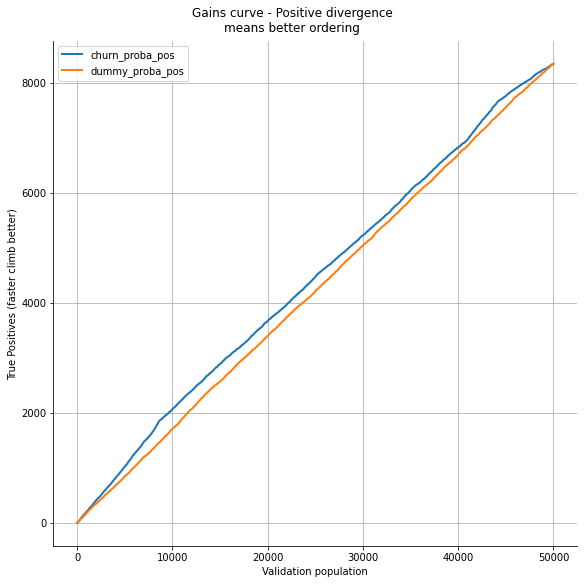

In [26]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
for key in keys:
    linestyle = "-"
    linewidth = 2
    if key in {"up_proba_c", "up_proba_t"}:
        linestyle = "--"
        linewidth = 1

    result_sorted = result.sort_values(key, ascending=False).reset_index()
    result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
    result_sorted.plot(
        kind="line",
        y="y_true_cum",
        ax=ax,
        label=key,
        linestyle=linestyle,
        linewidth=linewidth,
    )
ax.set_ylabel("True Positives (faster climb better)")
ax.set_xlabel("Validation population")

set_common_mpl_styles(ax, grid_axis="both")
# set_commas(ax, True, True)

# # zoom on x axis
# ax.set_xlim((45_000, result.shape[0]-1));
# ax.set_ylim(ymin=6000);

In [27]:
test_merged = pd.merge(
    left=result,
    right=ppl_val,
    left_index=True,
    right_index=True,
    validate="one_to_one",
)
assert test_merged.shape[0] == TEST_SIZE
test_merged.sample(10).sort_values("prob_churn").drop(
    columns=[]  # "dummy_proba_pos", "churn_proba_pos"]
)

,y_true,churn_proba_pos,dummy_proba_pos,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
36571,0,0.157992,0.16815,0,0,0,1,0.11,1,0
25391,0,0.160597,0.16815,0,0,0,0,0.16,1,0
4815,0,0.160597,0.16815,0,0,0,0,0.16,1,0
38724,0,0.160597,0.16815,0,0,0,0,0.16,1,0
36766,0,0.160597,0.16815,0,0,0,0,0.16,1,0
6272,0,0.160597,0.16815,0,0,0,0,0.16,1,0
40978,0,0.160597,0.16815,0,0,0,0,0.16,1,0
35768,0,0.208341,0.16815,0,1,0,1,0.16,1,0
5025,0,0.211568,0.16815,0,1,0,0,0.21,1,0
5061,0,0.158771,0.16815,0,0,1,0,0.21,1,0


In [28]:
test_merged["churn_proba_pos_bins"] = pd.cut(test_merged["churn_proba_pos"], 3)
# test_merged["churn_proba_pos_bins"] = pd.qcut(test_merged["churn_proba_pos"], 2)
features

['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']

# For each row in the test set, group and explain the features

If we order the data by predicted use of marketing to increase lift, we can count the underlying features - these should reflect the original distributions.

* sure things - have `brand_loyal` and don't respond to marketing, they're likelier to _stay_
* lost causes - have `bad_experience` and don't respond to marketing, they're likelier to _leave_
* persuadables - have `mkt_pos` as they respond well if marketed to, they're likelier to _stay_ conditional on marketing
* sleeping dogs - have `mkt_neg` as they respond negatively if marketed to, they're likelier to _leave_ conditional on marketing

In [29]:
res = test_merged.groupby("dummy_proba_pos").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
)
display(f"Base churn rate for all is circa {BASE_CHURN*100:0.1f}%")
display(
    "churn_proba_pos_bins is prob(churn), typically we market at the people with highest chance of churn"
)
res.style.pipe(summarise_groups_pretty, "Feature contributions to Churn prediction")

'Base churn rate for all is circa 16.0%'

'churn_proba_pos_bins is prob(churn), typically we market at the people with highest chance of churn'

,count,prob_churn_if_mktd,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,mkt_neg_sum
dummy_proba_pos,,,,,,
0.168150,50000,0.166880,4973,10055,2439,4937


In [30]:
# show bins in equal blocks
test_merged2 = test_merged.sort_values("churn_proba_pos_bins").copy()
test_merged2 = test_merged2.reset_index(drop=True)
test_merged2["binned_index"] = pd.cut(test_merged2.index, 10)

res = test_merged2.groupby("binned_index").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
    # up_proba_c_mean=pd.NamedAgg("up_proba_c", "mean"),
    # up_proba_t_mean=pd.NamedAgg("up_proba_t", "mean"),
    # uplift_diff_t_c=pd.NamedAgg("uplift_diff_t_c", "mean")
)
# res

res[::].style.pipe(
    summarise_groups_pretty, "Feature contributions to Uplift prediction"
)

,count,prob_churn_if_mktd,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,mkt_neg_sum
binned_index,,,,,,
"(-49.999, 4999.9]",5000,0.146000,513,41,1996,472
"(4999.9, 9999.8]",5000,0.167800,472,59,59,482
"(9999.8, 14999.7]",5000,0.160600,446,76,76,506
"(14999.7, 19999.6]",5000,0.157200,490,51,51,496
"(19999.6, 24999.5]",5000,0.163000,511,63,63,498
"(24999.5, 29999.4]",5000,0.147200,520,58,58,507
"(29999.4, 34999.3]",5000,0.158000,516,70,70,506
"(34999.3, 39999.2]",5000,0.155800,534,62,62,513
"(39999.2, 44999.1]",5000,0.209000,497,4575,4,465


In [31]:
res = test_merged.groupby("churn_proba_pos_bins").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
)
display(f"Base churn rate for all is circa {BASE_CHURN*100:0.1f}%")
display(
    "churn_proba_pos_bins is prob(churn), typically we market at the people with highest chance of churn"
)
res.style.pipe(summarise_groups_pretty, "Feature contributions to Churn prediction")

'Base churn rate for all is circa 16.0%'

'churn_proba_pos_bins is prob(churn), typically we market at the people with highest chance of churn'

,count,prob_churn_if_mktd,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,mkt_neg_sum
churn_proba_pos_bins,,,,,,
"(0.115, 0.148]",1955,0.104859,217,0,1955,187
"(0.148, 0.18]",38474,0.159692,3832,484,484,3834
"(0.18, 0.212]",9571,0.208442,924,9571,0,916


# Estimate value to business

## Churn comparison result

In [32]:
df_comparison = test_merged.sort_values(
    "churn_proba_pos", ascending=False
).copy()  # most likely needing marketing first
df_comparison = df_comparison[["churn_proba_pos", "will_churn"]].rename(
    columns={"will_churn": "churn_will_churn"}
)
df_comparison = df_comparison.reset_index(drop=True)

OUTFILE = "df_comparison_churn.pickle"
print(f"Writing to {OUTFILE} with {df_comparison.columns}")
df_comparison.to_pickle(OUTFILE)
# f_costing.plot(kind='line', y='value_generated_cumsum');

Writing to df_comparison_churn.pickle with Index(['churn_proba_pos', 'churn_will_churn'], dtype='object')


In [33]:
df_comparison = test_merged.sort_values(
    "dummy_proba_pos", ascending=False
).copy()  # most likely needing marketing first
df_comparison = df_comparison[["dummy_proba_pos", "will_churn"]].rename(
    columns={"will_churn": "dummy_will_churn"}
)
df_comparison = df_comparison.reset_index(drop=True)

OUTFILE = "df_comparison_dummy.pickle"
print(f"Writing to {OUTFILE} with {df_comparison.columns}")
df_comparison.to_pickle(OUTFILE)
# f_costing.plot(kind='line', y='value_generated_cumsum');

Writing to df_comparison_dummy.pickle with Index(['dummy_proba_pos', 'dummy_will_churn'], dtype='object')


In [34]:
datetime.datetime.now()

datetime.datetime(2022, 3, 30, 16, 36, 22, 151940)